# **02 - Iterative Modelling**

In [46]:
import pandas as pd
import geopandas as gpd
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import LineString
import warnings

warnings.filterwarnings('ignore')

## 1. Model V1: Baseline

This section implements the first version of the optimization model.
* **Strategy:** Maximin (Maximize the minimum score among species to ensure equity).
* **Connectivity:** High bonus ($5.0 \times scale$) to encourage clustering.
* **Constraints:** Budget, Topological continuity ($\ge 2$ neighbors), Biological conflicts.

### 1.1. Data Loading

In [47]:
print("Loading data...")

df = pd.read_csv('../2_data/processed/final_dataset.csv')
gdf_raw = gpd.read_file('../2_data/raw/dataset.geojson')

df['id_idx'] = range(len(df))
id_to_idx = dict(zip(df['grid_id'], df['id_idx']))

def parse_neighbors(neigh_str):
    """Parses the comma-separated neighbors string into a list of integer indices."""
    if pd.isna(neigh_str) or neigh_str == "": 
        return []
    return [id_to_idx[nid] for nid in neigh_str.split(',') if nid in id_to_idx]

df['neighbor_indices'] = df['neighbors'].apply(parse_neighbors)
print(f"Data loaded. Total cells: {len(df)}")

Loading data...
Data loaded. Total cells: 1401


### 1.2. Model Definition

Here we define the model class. It includes the variables for Habitats ($x$), Adaptations ($a$), and Corridors ($c$), along with the specific constraints and the **Maximin** objective function.

In [48]:
class ModelV1:
    def __init__(self, df, budget_euros):
        self.df = df
        self.budget = int(budget_euros)
        
        # Scaling Factors (CP-SAT requires integers)
        self.factor_cost_csv_to_euros = 1000 
        self.scale_suitability = 10  
        
        # Connectivity Bonus: High value to force clustering
        self.connectivity_bonus_val = int(5.0 * self.scale_suitability) 

        self.model = cp_model.CpModel()
        self.solver = cp_model.CpSolver()
        self.status = None
        
        self.species = ['atelerix', 'martes', 'eliomys', 'oryctolagus']
        self.full_species_names = {
            'atelerix': 'has_atelerix_algirus',
            'martes': 'has_martes_martes',
            'eliomys': 'has_eliomys_quercinus',
            'oryctolagus': 'has_oryctolagus_cuniculus'
        }
        self.vars = {} 

    def build_model(self):
        print(f"Building Model V1 (Maximin) - Budget: {self.budget} €...")
        num_cells = len(self.df)
        x, a, c = {}, {}, {}
        active = {} 
        
        # 1. Define Variables
        for i in range(num_cells):
            for s in self.species:
                x[i, s] = self.model.NewBoolVar(f'x_{i}_{s}')      # Habitat
                a[i, s] = self.model.NewBoolVar(f'a_{i}_{s}')      # Adaptation Action
                c[i, s] = self.model.NewBoolVar(f'c_{i}_{s}')      # Corridor
                
                # Auxiliary: Active if Habitat OR Corridor
                active[i, s] = self.model.NewBoolVar(f'active_{i}_{s}')
                self.model.AddMaxEquality(active[i, s], [x[i, s], c[i, s]])

        self.vars = {'x': x, 'a': a, 'c': c}
        
        total_cost_terms = []
        species_scores = {s: [] for s in self.species}
        processed_edges = set()

        # 2. Constraints per Cell
        for i in range(num_cells):
            row = self.df.iloc[i]
            cost_corr_val = int(row['cost_corridor'] * self.factor_cost_csv_to_euros)
            neighbors = row['neighbor_indices']
            
            # Pre-calculate edges for connectivity bonus
            current_edges = []
            for n in neighbors:
                if i < n:
                    if (i, n) not in processed_edges:
                        processed_edges.add((i, n))
                        current_edges.append(n)
            
            for s in self.species:
                # Initial presence check
                initial = 1 if row[self.full_species_names[s]] else 0
                cost_ad = int(row[f'cost_adaptation_{s}'] * self.factor_cost_csv_to_euros)
                
                # Logic: Adaptation and Presence
                self.model.Add(a[i, s] + initial >= x[i, s])
                self.model.Add(x[i, s] >= a[i, s])
                self.model.Add(x[i, s] + c[i, s] <= 1) # Cannot be Habitat and Corridor
                
                # Cost Accumulation
                total_cost_terms.append(a[i, s] * cost_ad)
                total_cost_terms.append(c[i, s] * cost_corr_val)
                
                # Topology: Corridor needs >= 2 active neighbors
                if neighbors:
                    vecinos_vars = [x[n, s] + c[n, s] for n in neighbors]
                    self.model.Add(sum(vecinos_vars) >= 2 * c[i, s])
                else:
                    self.model.Add(c[i, s] == 0)
                
                # Scoring: Suitability
                suit = int(row[f'suitability_{s}'] * self.scale_suitability)
                species_scores[s].append(x[i, s] * suit)
                
                # Scoring: Connectivity Bonus
                for n_idx in current_edges:
                     conn = self.model.NewBoolVar(f'conn_{i}_{n_idx}_{s}')
                     self.model.Add(conn <= active[i, s])
                     self.model.Add(conn <= active[n_idx, s])
                     species_scores[s].append(conn * self.connectivity_bonus_val)

            # Biological Conflict: Martes vs Eliomys
            self.model.Add(x[i, 'martes'] + x[i, 'eliomys'] <= 1)

        # 3. Budget Constraint
        self.model.Add(sum(total_cost_terms) <= self.budget)
        
        # 4. Objective: Maximin Strategy
        # Maximize the lowest species score (Equity) + Total Sum (Efficiency)
        z_min = self.model.NewIntVar(0, 2000000, 'min_score')
        totals = []
        for s in self.species:
            t = self.model.NewIntVar(0, 2000000, f'tot_{s}')
            self.model.Add(t == sum(species_scores[s]))
            self.model.Add(t >= z_min)
            totals.append(t)

        self.model.Maximize(1000 * z_min + sum(totals))

    def solve(self):
        print("Solving...")
        self.solver.parameters.max_time_in_seconds = 180.0 
        self.status = self.solver.Solve(self.model)
        
        if self.status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
            print(f"Solution Found! Status: {self.solver.StatusName(self.status)}")
            return True
        else:
            print("No solution found.")
            return False

    def get_results_df(self):
        """Extracts decision variables into a DataFrame."""
        if self.status not in [cp_model.OPTIMAL, cp_model.FEASIBLE]: return None
        results = []
        for i in range(len(self.df)):
            row_res = {'grid_id': self.df.iloc[i]['grid_id']}
            for s in self.species:
                is_h = self.solver.Value(self.vars['x'][i, s])
                is_c = self.solver.Value(self.vars['c'][i, s])
                if is_h: row_res[f'status_{s}'] = 'Habitat'
                elif is_c: row_res[f'status_{s}'] = 'Corridor'
                else: row_res[f'status_{s}'] = '-'
            results.append(row_res)
        return pd.DataFrame(results)

### 1.3. Execution & Solving

We instantiate the model with a budget of **€500,000** and run the solver. The results are merged back with the original spatial data for visualization.

In [49]:
budget = 500000.0

# Instantiate and Build
model_v1 = ModelV1(df, budget)
model_v1.build_model()

# Solve
if model_v1.solve():
    res_df = model_v1.get_results_df()
    
    # Merge results with original Geometry and Neighbor data
    gdf = gdf_raw.merge(res_df, on='grid_id')
    gdf = gdf.merge(df[['grid_id', 'neighbors']], on='grid_id', how='left')
    
    print("Results merged successfully.")
else:
    print("Model failed to solve.")

Building Model V1 (Maximin) - Budget: 500000 €...
Solving...
Solution Found! Status: FEASIBLE
Results merged successfully.


### 1.4. Visualization (Clean Network Map)

Visualizing the results. We apply a **distance filter** (`MAX_LINE_LENGTH_DEG`) to the corridors to avoid drawing unrealistic connections caused by data artifacts ("teleportation lines"). Corridors are drawn as lines connecting cell centers.

Generating map layers...
Map saved to: ../5_results/charts/map_v1_results.png


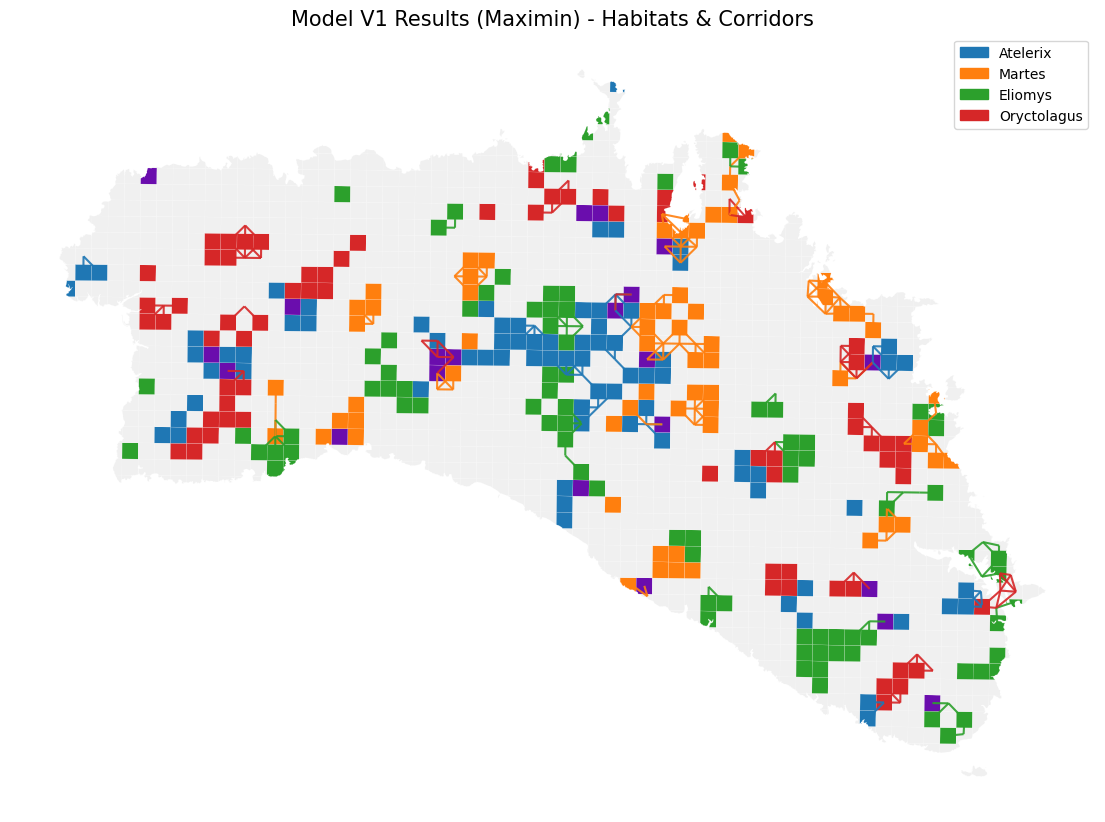

In [50]:
MAX_LINE_LENGTH_DEG = 0.02 

species_colors = {
    'atelerix': '#1f77b4', 'martes': '#ff7f0e', 
    'eliomys': '#2ca02c', 'oryctolagus': '#d62728'
}

# Pre-calculate centers for plotting
gdf['center'] = gdf.geometry.centroid
id_to_center = dict(zip(gdf['grid_id'], gdf['center']))
cell_info = gdf.set_index('grid_id').to_dict('index')

species_lines = []
processed = {s: set() for s in species_colors}

print("Generating map layers...")

for idx, row in gdf.iterrows():
    gid = row['grid_id']
    n_str = row['neighbors']
    if pd.isna(n_str): continue
    
    # Parse neighbors
    n_ids = [nid.strip() for nid in str(n_str).split(',')]
    start_pt = id_to_center[gid]
    
    # Iterate over species to find Corridors
    for s, color in species_colors.items():
        if row[f'status_{s}'] == 'Corridor':
            for nid in n_ids:
                if nid in cell_info:
                    n_stat = cell_info[nid][f'status_{s}']
                    
                    # Connect if neighbor is part of the network (Habitat or Corridor)
                    if n_stat in ['Corridor', 'Habitat']:
                        end_pt = id_to_center[nid]
                        
                        # Distance Filter
                        if start_pt.distance(end_pt) > MAX_LINE_LENGTH_DEG: continue
                        
                        # Avoid duplicates (A-B and B-A)
                        link = tuple(sorted((gid, nid)))
                        if link not in processed[s]:
                            processed[s].add(link)
                            species_lines.append({
                                'geometry': LineString([start_pt, end_pt]), 
                                'color': color
                            })

# --- PLOTTING ---
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Helper to determine cell background color (Habitat)
def get_face_color(row):
    active = [c for s, c in species_colors.items() if row[f'status_{s}'] == 'Habitat']
    if not active: return '#f0f0f0'
    return active[0] if len(active)==1 else '#6a0dad' # Purple for overlap

# 1. Plot Cells (Habitats)
gdf['c'] = gdf.apply(get_face_color, axis=1)
gdf.plot(ax=ax, color=gdf['c'], edgecolor='white', linewidth=0.1)

# 2. Plot Corridors (Lines)
if species_lines:
    gdf_lines = gpd.GeoDataFrame(species_lines, crs=gdf.crs)
    gdf_lines.plot(ax=ax, color=gdf_lines['color'], linewidth=1.5, alpha=0.9)

ax.set_title("Model V1 Results (Maximin) - Habitats & Corridors", fontsize=15)
ax.set_axis_off()

# Legend
patches = [mpatches.Patch(color=c, label=s.capitalize()) for s, c in species_colors.items()]
plt.legend(handles=patches, loc='upper right')

output_path = '../5_results/charts/map_v1_results.png'
plt.savefig(output_path, dpi=300)
print(f"Map saved to: {output_path}")
plt.show()

## 2. Model V2

This section implements the second version of the optimization model.